Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset root: /content/drive/MyDrive/puffin/archive(1)
Image folder: /content/drive/MyDrive/puffin/archive(1)/Img
Exists?: True True
Using CSV: /content/drive/MyDrive/puffin/archive(1)/english.csv
CSV columns: ['image', 'label']
Detected file column: image
Detected label column: label
Images found: 3410
Loading and preprocessing images...


100%|██████████| 3410/3410 [01:09<00:00, 48.85it/s]


X shape: (3410, 784) y shape: (3410,)
Detected classes: 62
Train/test sizes: 2728 682
Starting hyperparameter search over 9 combinations...
Trained PLA for class 0 (0)
Trained PLA for class 1 (1)
Trained PLA for class 2 (2)
Trained PLA for class 3 (3)
Trained PLA for class 4 (4)
Trained PLA for class 5 (5)
Trained PLA for class 6 (6)
Trained PLA for class 7 (7)
Trained PLA for class 8 (8)
Trained PLA for class 9 (9)
Trained PLA for class A (10)
Trained PLA for class B (11)
Trained PLA for class C (12)
Trained PLA for class D (13)
Trained PLA for class E (14)
Trained PLA for class F (15)
Trained PLA for class G (16)
Trained PLA for class H (17)
Trained PLA for class I (18)
Trained PLA for class J (19)
Trained PLA for class K (20)
Trained PLA for class L (21)
Trained PLA for class M (22)
Trained PLA for class N (23)
Trained PLA for class O (24)
Trained PLA for class P (25)
Trained PLA for class Q (26)
Trained PLA for class R (27)
Trained PLA for class S (28)
Trained PLA for class T (29)


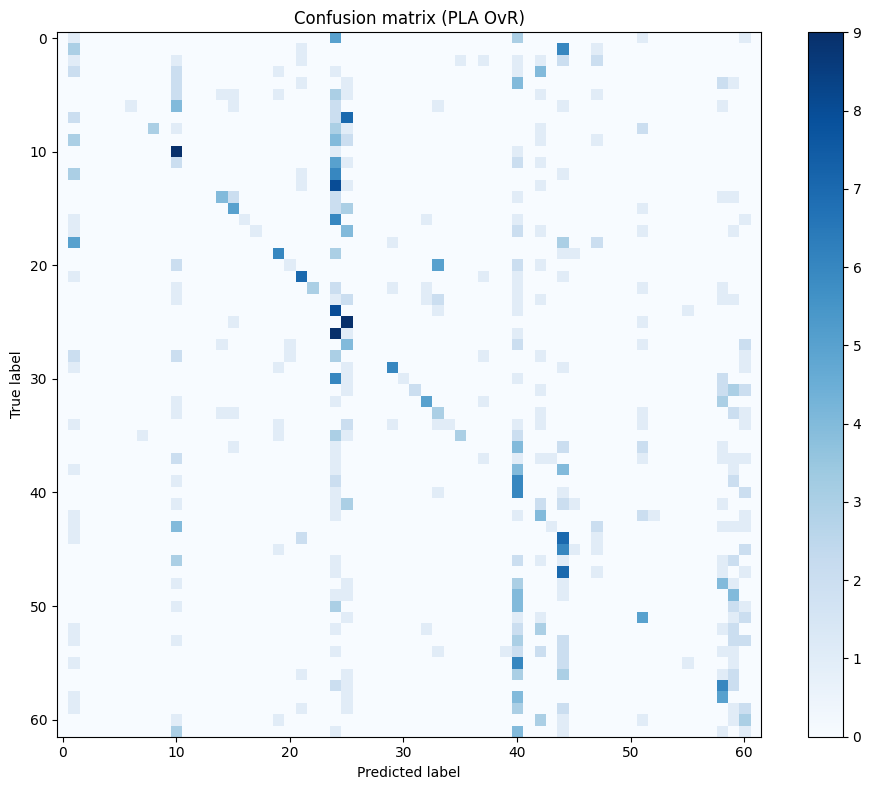

ROC AUC (micro): 0.7899574744108429
ROC AUC (macro): 0.8507501824650038


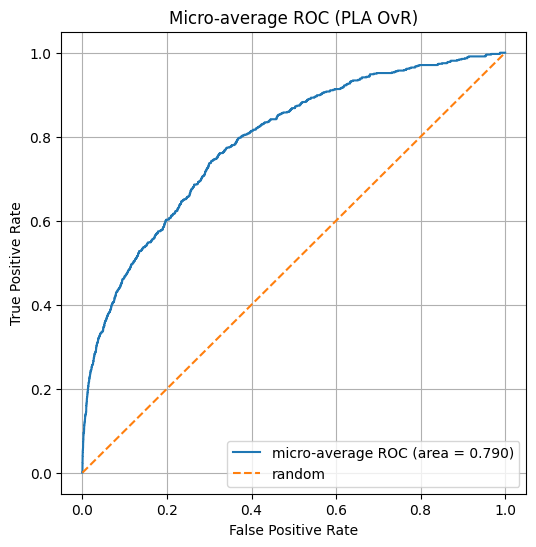

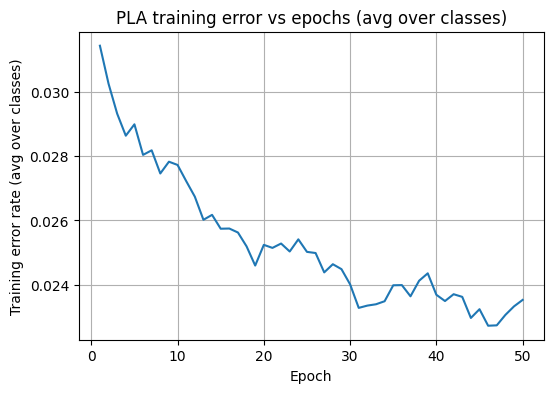

Saved PLA model weights & best params to /content/pla_ovr_models.pkl
Summary:
 - Num classes: 62
 - Train samples: 2728, Test samples: 682
 - Best LR, epochs: (0.01, 50)
 - Validation accuracy (best): 0.1832
 - Accuracy (test): 0.1730, Macro F1: 0.1367


In [6]:
# === PLA (Perceptron Learning Algorithm) Colab-ready implementation (with hyperparam search) ===
# Paste this into a single Colab cell and run.

# 1) Setup & mount drive
from google.colab import drive
drive.mount('/content/drive')

# Update this path if needed:
DATASET_ROOT = '/content/drive/MyDrive/puffin/archive(1)'
IMG_FOLDER = DATASET_ROOT + '/Img'  # expected folder of images

import os
print("Dataset root:", DATASET_ROOT)
print("Image folder:", IMG_FOLDER)
print("Exists?:", os.path.exists(DATASET_ROOT), os.path.exists(IMG_FOLDER))

# 2) Dependencies
!pip install --quiet tqdm
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import glob, sys
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             confusion_matrix, roc_curve, auc, roc_auc_score)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle

# 3) CSV auto-detect & image loader (robust to common column names)
def find_csv_file(dataset_root):
    # try to find a csv in dataset_root
    candidates = [f for f in os.listdir(dataset_root) if f.lower().endswith('.csv')]
    if not candidates:
        raise FileNotFoundError(f"No CSV file found in {dataset_root}. Place CSV in that folder.")
    # pick first candidate (or change logic if multiple)
    return os.path.join(dataset_root, candidates[0])

CSV_PATH = find_csv_file(DATASET_ROOT)
print("Using CSV:", CSV_PATH)

df = pd.read_csv(CSV_PATH)
print("CSV columns:", df.columns.tolist())
df = df.dropna(axis=0, how='any').reset_index(drop=True)

# try to detect filename and label columns
possible_file_cols = ['filename','file','image','img','path','image_path','file_name','File']
possible_label_cols = ['label','class','target','y','label_name','Label']
file_col = None
label_col = None
for c in df.columns:
    low = c.lower()
    if low in possible_file_cols or any(p in low for p in possible_file_cols):
        file_col = c
    if low in possible_label_cols or any(p in low for p in possible_label_cols):
        label_col = c

# If not auto-detected, use first two columns (best-effort)
if file_col is None:
    file_col = df.columns[0]
if label_col is None:
    # prefer second column if exists
    label_col = df.columns[1] if len(df.columns) > 1 else df.columns[0]

print("Detected file column:", file_col)
print("Detected label column:", label_col)

# 4) Image preprocessing function
from pathlib import Path
def load_and_preprocess(img_path, size=(28,28), as_gray=True):
    # loads image, converts to grayscale, resizes, returns flattened normalized vector
    img = Image.open(img_path)
    if as_gray:
        img = img.convert('L')  # grayscale
    img = img.resize(size, Image.BILINEAR)
    arr = np.asarray(img, dtype=np.float32)
    arr = arr / 255.0  # normalize to [0,1]
    return arr.flatten()

# 5) Build dataset arrays
image_paths = []
labels = []
missing_files = []
for idx, row in df.iterrows():
    fname = str(row[file_col])
    # if CSV paths are absolute, use them; otherwise, try in IMG_FOLDER
    full_path = fname
    if not os.path.isabs(full_path):
        # try joined with IMG_FOLDER
        p1 = os.path.join(IMG_FOLDER, fname)
        p2 = os.path.join(IMG_FOLDER, os.path.basename(fname))
        if os.path.exists(p1):
            full_path = p1
        elif os.path.exists(p2):
            full_path = p2
        else:
            # also try dataset root
            p3 = os.path.join(DATASET_ROOT, fname)
            if os.path.exists(p3):
                full_path = p3
            else:
                missing_files.append(fname)
                continue
    image_paths.append(full_path)
    labels.append(row[label_col])

if missing_files:
    print(f"Warning: {len(missing_files)} files listed in CSV were not found in Img folder. Example missing:", missing_files[:5])

print("Images found:", len(image_paths))
# Optionally limit for quick experiments:
# max_samples = 2000
# image_paths = image_paths[:max_samples]
# labels = labels[:max_samples]

# load images (this may take time)
X_list = []
print("Loading and preprocessing images...")
for p in tqdm(image_paths):
    X_list.append(load_and_preprocess(p, size=(28,28)))  # 28x28 resize
X = np.vstack(X_list)  # shape: (n_samples, features)
y = np.array(labels)

print("X shape:", X.shape, "y shape:", y.shape)

# 6) Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)  # integer labels 0..(C-1)
classes = le.classes_
n_classes = len(classes)
print("Detected classes:", n_classes)

# 7) One-vs-Rest PLA implementation
class PerceptronPLA:
    def __init__(self, n_features, lr=1.0):
        # We include bias as last weight
        self.lr = lr
        self.w = np.zeros(n_features + 1, dtype=np.float32)  # bias appended

    def predict_raw(self, X):
        # X: (n_samples, n_features)
        Xb = np.hstack([X, np.ones((X.shape[0],1), dtype=np.float32)])  # bias column=1
        scores = Xb.dot(self.w)
        return scores

    def predict(self, X):
        # step activation: sign(score) -> {1, -1}
        scores = self.predict_raw(X)
        return np.where(scores >= 0, 1, -1)

    def fit(self, X, y, epochs=10, shuffle=True, verbose=False):
        # y must be in {1, -1}
        Xb = np.hstack([X, np.ones((X.shape[0],1), dtype=np.float32)])
        n = X.shape[0]
        history = []
        for ep in range(epochs):
            errors = 0
            indices = np.arange(n)
            if shuffle:
                np.random.shuffle(indices)
            for i in indices:
                xi = Xb[i]
                yi = y[i]
                pred = 1 if xi.dot(self.w) >= 0 else -1
                if pred != yi:
                    # update rule: w_{t+1} = w_t + eta*(y - y_hat)*x
                    # for perceptron (y in {1,-1}) update is eta*y*x when misclassified
                    self.w += self.lr * yi * xi
                    errors += 1
            history.append(errors / n)
            if verbose:
                print(f"Epoch {ep+1}/{epochs} - training error rate: {history[-1]:.4f}")
        return history

# 8) Train OvR perceptrons, one per class
def train_ovr_pla(X_train, y_train, lr=1.0, epochs=20):
    n_features = X_train.shape[1]
    models = {}
    history = {}
    for c_idx, c_label in enumerate(classes):
        # create binary labels for this class: +1 for class c_idx, -1 otherwise
        y_bin = np.where(y_train == c_idx, 1, -1)
        p = PerceptronPLA(n_features, lr=lr)
        hist = p.fit(X_train, y_bin, epochs=epochs, shuffle=True, verbose=False)
        models[c_idx] = p
        history[c_idx] = hist
        print(f"Trained PLA for class {c_label} ({c_idx})")
    return models, history

# 9) Train/test split
X_train, X_test, y_train_idx, y_test_idx = train_test_split(X, y_enc, test_size=0.2, stratify=y_enc, random_state=42)
print("Train/test sizes:", X_train.shape[0], X_test.shape[0])

# --- HYPERPARAMETER SEARCH (inserted here) ---
# Grid to search (customize as needed)
lr_values = [1.0, 0.1, 0.01]
epoch_values = [10, 20, 50]

best_acc = 0.0
best_params = None
best_models = None
best_history = None

# internal train/validation split from X_train for hyperparameter evaluation
search_X_tr, search_X_val, search_y_tr, search_y_val = train_test_split(
    X_train, y_train_idx, test_size=0.2, stratify=y_train_idx, random_state=42
)

print("Starting hyperparameter search over", len(lr_values)*len(epoch_values), "combinations...")
for lr in lr_values:
    for ep in epoch_values:
        # Train candidate OvR models
        candidate_models, candidate_hist = train_ovr_pla(search_X_tr, search_y_tr, lr=lr, epochs=ep)
        # Predict on validation set
        def ovr_predict_local(models, X_input):
            n_samples = X_input.shape[0]
            scores_loc = np.zeros((n_samples, len(models)), dtype=np.float32)
            for c_idx, m in models.items():
                scores_loc[:, c_idx] = m.predict_raw(X_input)
            preds_loc = np.argmax(scores_loc, axis=1)
            return preds_loc
        val_preds = ovr_predict_local(candidate_models, search_X_val)
        acc = accuracy_score(search_y_val, val_preds)
        print(f"lr={lr}, epochs={ep} -> val_acc={acc:.4f}")
        if acc > best_acc:
            best_acc = acc
            best_params = (lr, ep)
            best_models = candidate_models
            best_history = candidate_hist

print("\nBest Params:", best_params, "Validation Accuracy:", best_acc)

# Retrain best model(s) on the ENTIRE training set (X_train) using best hyperparams
if best_params is not None:
    best_lr, best_ep = best_params
    print(f"\nRetraining OvR PLA on full training set with lr={best_lr}, epochs={best_ep} ...")
    models, hist = train_ovr_pla(X_train, y_train_idx, lr=best_lr, epochs=best_ep)
else:
    # fallback to default if search failed
    print("No best params found — falling back to LR=1.0, EPOCHS=30")
    best_lr, best_ep = 1.0, 30
    models, hist = train_ovr_pla(X_train, y_train_idx, lr=best_lr, epochs=best_ep)

# 11) Predict function combining OvR decisions: select class with largest raw score
def ovr_predict(models, X):
    # models: dict[class_idx] -> PerceptronPLA
    n = X.shape[0]
    scores = np.zeros((n, len(models)), dtype=np.float32)
    for c_idx, model in models.items():
        scores[:, c_idx] = model.predict_raw(X)
    # choose argmax of scores
    preds = np.argmax(scores, axis=1)
    return preds, scores

y_pred_idx, raw_scores_test = ovr_predict(models, X_test)

# 12) Evaluation: accuracy, precision, recall, f1
acc = accuracy_score(y_test_idx, y_pred_idx)
prec, rec, f1, _ = precision_recall_fscore_support(y_test_idx, y_pred_idx, average='macro', zero_division=0)
print("PLA (OvR) Results:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision (macro): {prec:.4f}")
print(f"Recall (macro): {rec:.4f}")
print(f"F1-score (macro): {f1:.4f}")

# Detailed per-class metrics
prec_pc, rec_pc, f1_pc, _ = precision_recall_fscore_support(y_test_idx, y_pred_idx, average=None, labels=range(n_classes), zero_division=0)
per_class_df = pd.DataFrame({
    'class_label': classes,
    'precision': prec_pc,
    'recall': rec_pc,
    'f1': f1_pc
})
print(per_class_df.to_string(index=False))

# 13) Confusion matrix (plot)
cm = confusion_matrix(y_test_idx, y_pred_idx, labels=range(n_classes))
plt.figure(figsize=(10,8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix (PLA OvR)')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.colorbar()
plt.tight_layout()
plt.show()

# 14) ROC curves (multiclass) - compute micro & macro AUC
# we need binarized true labels and score matrix
y_test_bin = label_binarize(y_test_idx, classes=range(n_classes))  # shape (n_samples, n_classes)
# raw_scores_test shape already (n_samples, n_classes)
# compute ROC AUC scores
try:
    roc_auc_micro = roc_auc_score(y_test_bin, raw_scores_test, average='micro', multi_class='ovr')
    roc_auc_macro = roc_auc_score(y_test_bin, raw_scores_test, average='macro', multi_class='ovr')
    print("ROC AUC (micro):", roc_auc_micro)
    print("ROC AUC (macro):", roc_auc_macro)
except Exception as e:
    print("ROC AUC computation failed (likely due to insufficient positive samples per class). Error:", e)

# Plot sample ROC curves: micro-average
from sklearn.metrics import roc_curve, auc
# compute micro-average ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), raw_scores_test.ravel())
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'micro-average ROC (area = {roc_auc:.3f})')
plt.plot([0,1],[0,1],'--', label='random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC (PLA OvR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 15) Training error vs epochs (averaged over classes)
# hist is dict[class_idx] -> [err_epoch1, err_epoch2, ...]
# make arrays same length if possible
hist_lengths = [len(h) for h in hist.values()]
min_len = min(hist_lengths) if hist_lengths else 0
if min_len == 0:
    print("No training history available to plot.")
else:
    # truncate to min_len to safely average
    hist_matrix = np.array([hist[c][:min_len] for c in sorted(hist.keys())])
    avg_err_per_epoch = np.mean(hist_matrix, axis=0)
    plt.figure(figsize=(6,4))
    plt.plot(range(1, len(avg_err_per_epoch)+1), avg_err_per_epoch)
    plt.xlabel('Epoch')
    plt.ylabel('Training error rate (avg over classes)')
    plt.title('PLA training error vs epochs (avg over classes)')
    plt.grid(True)
    plt.show()

# 16) Save model weights (optional)
save_path = '/content/pla_ovr_models.pkl'
with open(save_path, 'wb') as f:
    pickle.dump({
        'best_params': best_params,
        'validation_accuracy': best_acc,
        'models': {c: m.w for c, m in models.items()},
        'label_encoder': le
    }, f)
print("Saved PLA model weights & best params to", save_path)

# 17) Print a short result summary
print("Summary:")
print(f" - Num classes: {n_classes}")
print(f" - Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")
print(f" - Best LR, epochs: {best_params}")
print(f" - Validation accuracy (best): {best_acc:.4f}")
print(f" - Accuracy (test): {acc:.4f}, Macro F1: {f1:.4f}")

# === End of PLA implementation cell ===

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset root: /content/drive/MyDrive/puffin/archive(1)
Image folder: /content/drive/MyDrive/puffin/archive(1)/Img
Exists?: True True
Using device: cpu
Using CSV: /content/drive/MyDrive/puffin/archive(1)/english.csv
CSV columns: ['image', 'label']
Detected file column: image
Detected label column: label
Resolved images: 3410 Missing entries: 0


Loading images: 100%|██████████| 3410/3410 [01:07<00:00, 50.48it/s]


Loaded X: (3410, 784) y: (3410,)
Num classes: 62
Shapes -> train: (2182, 784) val: (546, 784) test: (682, 784)
DEBUG mode: using small search space. Set SPEEDUP_DEBUG=False to run full grid.


Grid search: 100%|██████████| 2/2 [00:11<00:00,  5.56s/it]



Grid search finished in 11.1s
Best Params: (64, 0.001, 128, 'relu', 'adam', 1)
Best Val Accuracy: 0.016483516483516484

MLP Test Accuracy: 0.016129032258064516

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00        11
           3       0.00      0.00      0.00        11
           4       0.00      0.00      0.00        11
           5       0.00      0.00      0.00        11
           6       0.00      0.00      0.00        11
           7       0.00      0.00      0.00        11
           8       0.00      0.00      0.00        11
           9       0.00      0.00      0.00        11
           A       0.00      0.00      0.00        11
           B       0.00      0.00      0.00        11
           C       0.00      0.00      0.00        11
           D       0.00      0.00      0.00        11
   

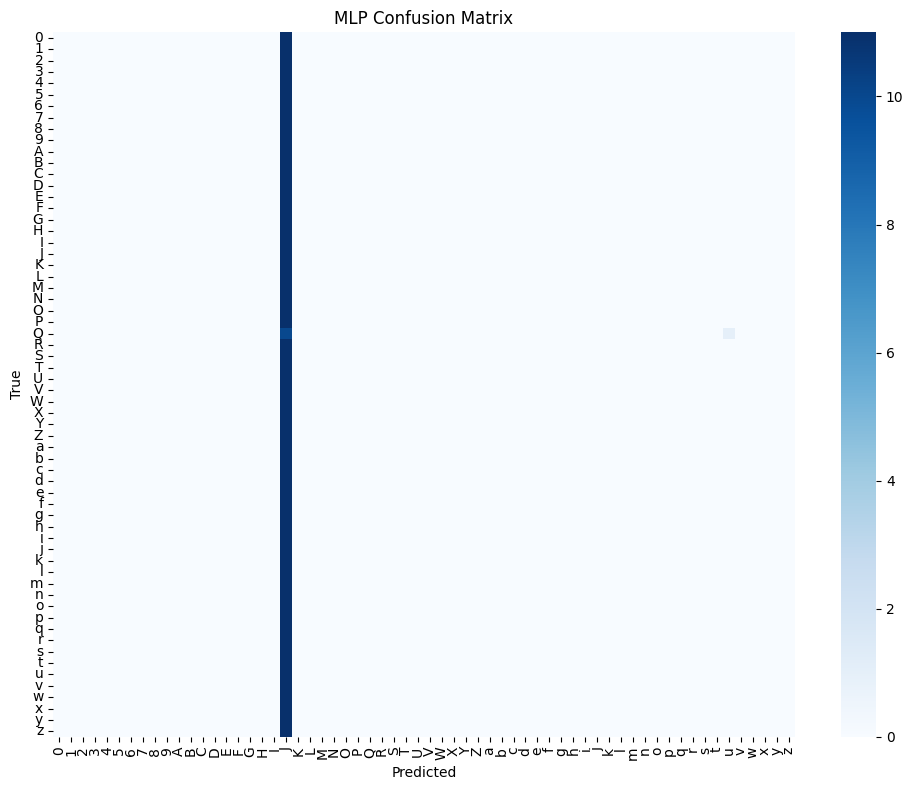

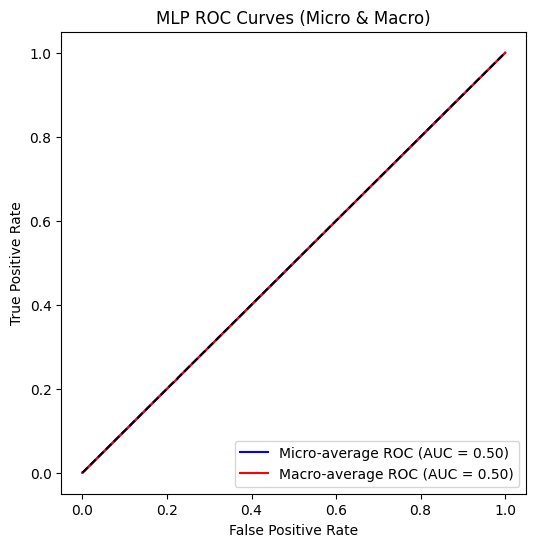

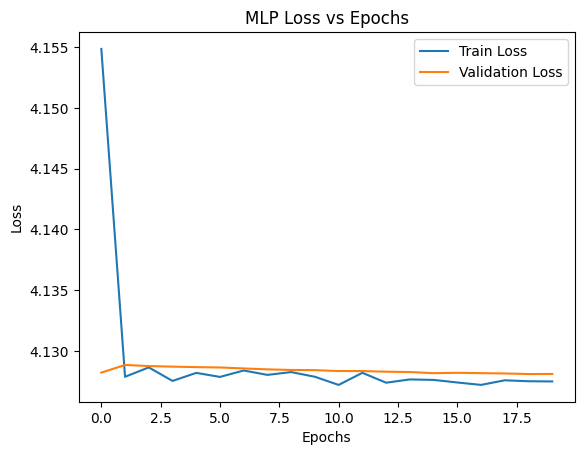

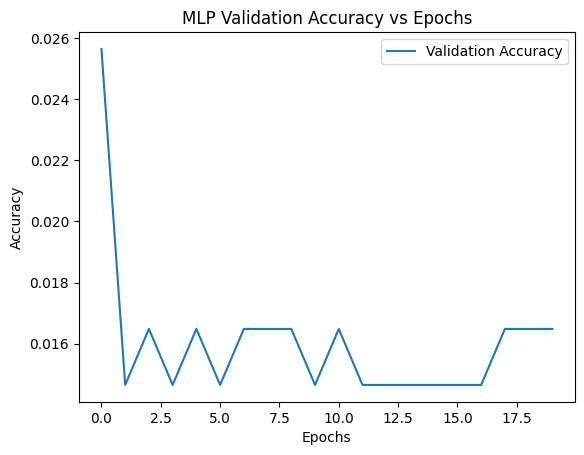

Saved best MLP model to /content/mlp_best_model.pth

Summary:
 - Num classes: 62
 - Train: 2182 Val: 546 Test: 682
 - Best params: (64, 0.001, 128, 'relu', 'adam', 1)
 - Best val acc: 0.016483516483516484
 - Test acc: 0.016129032258064516


In [9]:
# === MLP (Multilayer Perceptron) — corrected single-cell for Colab ===
# Paste & run. (If runtime has a GPU, use Runtime -> Change runtime type -> GPU for faster training.)

# 1) Mount Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

DATASET_ROOT = '/content/drive/MyDrive/puffin/archive(1)'
IMG_FOLDER = DATASET_ROOT + '/Img'
import os, pickle, time
print("Dataset root:", DATASET_ROOT)
print("Image folder:", IMG_FOLDER)
print("Exists?:", os.path.exists(DATASET_ROOT), os.path.exists(IMG_FOLDER))

# 2) Install / imports
!pip install --quiet tqdm torch torchvision seaborn
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             confusion_matrix, roc_auc_score, roc_curve, auc, classification_report)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 3) CSV finder + load (same strategy as before)
def find_csv_file(dataset_root):
    candidates = [f for f in os.listdir(dataset_root) if f.lower().endswith('.csv')]
    if not candidates:
        raise FileNotFoundError(f"No CSV file found in {dataset_root}.")
    return os.path.join(dataset_root, candidates[0])

CSV_PATH = find_csv_file(DATASET_ROOT)
print("Using CSV:", CSV_PATH)
df = pd.read_csv(CSV_PATH).dropna().reset_index(drop=True)
print("CSV columns:", df.columns.tolist())

# 4) detect file & label columns (best-effort)
possible_file_cols = ['filename','file','image','img','path','image_path','file_name']
possible_label_cols = ['label','class','target','y']
file_col = next((c for c in df.columns if any(p in c.lower() for p in possible_file_cols)), df.columns[0])
label_col = next((c for c in df.columns if any(p in c.lower() for p in possible_label_cols)), (df.columns[1] if len(df.columns)>1 else df.columns[0]))
print("Detected file column:", file_col)
print("Detected label column:", label_col)

# 5) build X,y using the same preprocessing as earlier: grayscale 28x28 flatten
def resolve_image_path(fname, img_folder, dataset_root):
    if os.path.isabs(fname) and os.path.exists(fname):
        return fname
    p1 = os.path.join(img_folder, fname); p2 = os.path.join(img_folder, os.path.basename(fname))
    p3 = os.path.join(dataset_root, fname)
    if os.path.exists(p1): return p1
    if os.path.exists(p2): return p2
    if os.path.exists(p3): return p3
    # recursive search by basename
    base = os.path.basename(fname).lower()
    if os.path.exists(img_folder):
        for root, _, files in os.walk(img_folder):
            for f in files:
                if f.lower() == base:
                    return os.path.join(root, f)
    for root, _, files in os.walk(dataset_root):
        for f in files:
            if f.lower() == base:
                return os.path.join(root, f)
    return None

def load_and_preprocess(img_path, size=(28,28)):
    img = Image.open(img_path).convert("L").resize(size, Image.BILINEAR)
    arr = np.asarray(img, dtype=np.float32)/255.0
    return arr.flatten()

image_paths, labels = [], []
missing = []
for _, row in df.iterrows():
    fname = str(row[file_col])
    resolved = resolve_image_path(fname, IMG_FOLDER, DATASET_ROOT)
    if resolved:
        image_paths.append(resolved)
        labels.append(row[label_col])
    else:
        missing.append(fname)

print("Resolved images:", len(image_paths), "Missing entries:", len(missing))
if len(image_paths) == 0:
    raise ValueError("No images found. Check CSV and Img folder.")

X_list = []
failed = []
for p in tqdm(image_paths, desc="Loading images"):
    try:
        X_list.append(load_and_preprocess(p, size=(28,28)))
    except Exception as e:
        failed.append((p,str(e)))
if failed:
    print("Warning: some images failed to load. Example:", failed[:3])

X = np.vstack(X_list)
y_raw = np.array(labels)
print("Loaded X:", X.shape, "y:", y_raw.shape)

# 6) Encode labels and splits (match friend's layout: train_full -> train/val)
le = LabelEncoder()
y = le.fit_transform(y_raw)
print("Num classes:", len(le.classes_))

RNG_SEED = 42
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RNG_SEED
)
# split train_full into train and val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=RNG_SEED
)
print("Shapes -> train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)

# convert to tensors and dataloaders helper
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)
X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_t = torch.tensor(y_val, dtype=torch.long).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.long).to(device)

def get_loader(Xt, yt, batch_size, shuffle=True):
    ds = TensorDataset(Xt, yt)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

# 7) MLP model class (fixed __init__ and super init)
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation="relu", num_hidden=1):
        super(MLP, self).__init__()
        act_fn = {"relu": nn.ReLU(), "tanh": nn.Tanh(), "sigmoid": nn.Sigmoid()}[activation]
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(act_fn)
        if num_hidden == 2:
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(act_fn)
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

# 8) training function (EPOCHS = 20 while searching)
def train_model(params, epochs=20):
    batch_size, lr, hidden_dim, activation, optimizer_name, num_hidden = params
    train_loader = get_loader(X_train_t, y_train_t, batch_size=batch_size, shuffle=True)
    val_loader = get_loader(X_val_t, y_val_t, batch_size=batch_size, shuffle=False)
    model = MLP(X_train.shape[1], hidden_dim, len(le.classes_), activation, num_hidden).to(device)
    criterion = nn.CrossEntropyLoss()
    if optimizer_name == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=lr)
    else:
        optimizer = optim.Adam(model.parameters(), lr=lr)
    history = {"train_loss": [], "val_loss": [], "val_acc": []}
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        # validation
        model.eval()
        val_loss = 0.0
        correct = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                out = model(xb)
                loss = criterion(out, yb)
                val_loss += loss.item()
                preds = out.argmax(dim=1)
                correct += (preds == yb).sum().item()
        acc = correct / len(val_loader.dataset)
        history["train_loss"].append(train_loss / max(1, len(train_loader)))
        history["val_loss"].append(val_loss / max(1, len(val_loader)))
        history["val_acc"].append(acc)
    return model, history

# 9) Search space
SPEEDUP_DEBUG = True  # set False to run full grid; True uses a tiny debug grid for quick iteration
if SPEEDUP_DEBUG:
    search_space = [
        (64, 0.01, 128, "relu", "adam", 1),
        (64, 0.001, 128, "relu", "adam", 1),
    ]
    print("DEBUG mode: using small search space. Set SPEEDUP_DEBUG=False to run full grid.")
else:
    search_space = [
        (bs, lr, hd, act, opt, nh)
        for bs in [32, 64, 128]
        for lr in [0.1, 0.01, 0.001]
        for hd in [128, 256]
        for act in ["relu", "tanh", "sigmoid"]
        for opt in ["sgd", "adam"]
        for nh in [1, 2]
    ]

from tqdm import tqdm
best_acc, best_params, best_model, best_history = 0, None, None, None

start_time = time.time()
for params in tqdm(search_space, desc="Grid search"):
    model_cand, hist_cand = train_model(params, epochs=20)
    final_val_acc = hist_cand["val_acc"][-1]
    if final_val_acc > best_acc:
        best_acc = final_val_acc
        best_params = params
        best_model = model_cand
        best_history = hist_cand

print("\nGrid search finished in {:.1f}s".format(time.time()-start_time))
print("Best Params:", best_params)
print("Best Val Accuracy:", best_acc)

# 10) Evaluate best model on test set (use probabilities)
if best_model is None:
    raise RuntimeError("No model was trained. Check search_space and SPEEDUP_DEBUG flag.")

best_model.eval()
with torch.no_grad():
    out_test = best_model(X_test_t)
    probs = torch.softmax(out_test, dim=1).cpu().numpy()
    preds = probs.argmax(axis=1)
    preds_cpu = preds  # already numpy

y_test_cpu = y_test  # original numpy labels
print("\nMLP Test Accuracy:", accuracy_score(y_test_cpu, preds_cpu))
print("\nClassification Report:\n")
print(classification_report(y_test_cpu, preds_cpu, target_names=le.classes_, zero_division=0))

# 11) Confusion Matrix
cm = confusion_matrix(y_test_cpu, preds_cpu)
plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_, cbar=True, annot=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("MLP Confusion Matrix")
plt.tight_layout()
plt.show()

# 12) ROC Curves (Micro & Macro) using predicted probabilities
try:
    y_test_bin = label_binarize(y_test_cpu, classes=np.arange(len(le.classes_)))
    fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), probs.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)

    fpr_dict, tpr_dict, roc_auc_dict = {}, {}, {}
    for i in range(len(le.classes_)):
        fpr_dict[i], tpr_dict[i], _ = roc_curve(y_test_bin[:, i], probs[:, i])
        roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])

    all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(len(le.classes_))]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(le.classes_)):
        mean_tpr += np.interp(all_fpr, fpr_dict[i], tpr_dict[i])
    mean_tpr /= len(le.classes_)
    roc_auc_macro = auc(all_fpr, mean_tpr)

    plt.figure(figsize=(6,6))
    plt.plot(fpr_micro, tpr_micro, label=f"Micro-average ROC (AUC = {roc_auc_micro:.2f})", color="blue")
    plt.plot(all_fpr, mean_tpr, label=f"Macro-average ROC (AUC = {roc_auc_macro:.2f})", color="red")
    plt.plot([0,1], [0,1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("MLP ROC Curves (Micro & Macro)")
    plt.legend(loc="lower right")
    plt.show()
except Exception as e:
    print("ROC calculation/plotting failed:", e)

# 13) Loss & Val Accuracy plots for the best history
if best_history is not None:
    plt.figure()
    plt.plot(best_history["train_loss"], label="Train Loss")
    plt.plot(best_history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("MLP Loss vs Epochs")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(best_history["val_acc"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("MLP Validation Accuracy vs Epochs")
    plt.legend()
    plt.show()

# 14) Save best model and encoder (optional)
save_path = "/content/mlp_best_model.pth"
torch.save({"model_state": best_model.state_dict(), "best_params": best_params, "label_encoder_classes": le.classes_}, save_path)
print("Saved best MLP model to", save_path)

# 15) Final summary
print("\nSummary:")
print(" - Num classes:", len(le.classes_))
print(" - Train:", X_train.shape[0], "Val:", X_val.shape[0], "Test:", X_test.shape[0])
print(" - Best params:", best_params)
print(" - Best val acc:", best_acc)
print(" - Test acc:", accuracy_score(y_test_cpu, preds_cpu))
